<a href="https://colab.research.google.com/github/Muhammadsulton1/MIPT_Data_analys/blob/main/Lesson_11_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Семинар 11 (неделя 13): Анализ временных рядов
===
Часть 2
=====

In [ ]:
# Импорт библиотек для работы со статистикой
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm

# Импорт библиотек для построения графиков
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.utils.plotting import plot_series

# Стиль для графиков
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Тест на стационарность

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

In [ ]:
ENP = pd.read_csv('../Lesson_11/opsd_germany_daily.csv',
                  index_col = 0,
                  parse_dates = True
                 ).asfreq('D')

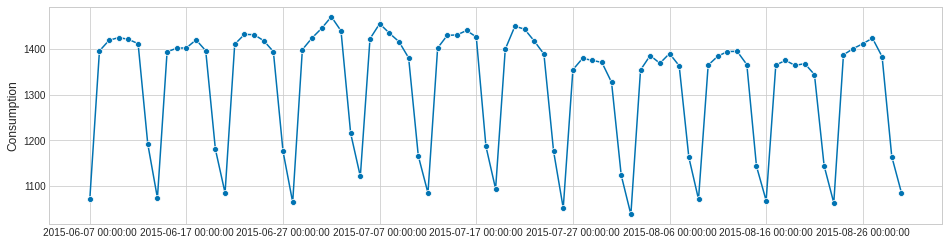

In [ ]:
#y = ENP['Consumption'].loc['2015-05-01':'2015-08-30']
y = ENP['Consumption'].loc['2015-06-07':'2015-08-30']

#y = ENP['Consumption'].loc['2010-08-01':'2010-12-01']
plot_series(y);

Нулевая гипотеза теста Дики-Фуллера — ряд не стационарен
```adfuller(y, regression='c', autolag='AIC')```

Для KPSS-теста нулевая гипотеза заключается в стационарности ряда
```kpss(y, regression='c')```

тесты можно проводить против разных альтернатив, в зависимости от того, что мы видим в данных:

    * "c" : constant only (default).
    * "ct" : constant and trend.
    * "ctt" : constant, and linear and quadratic trend.
    * "nc" : no constant, no trend.

In [ ]:
adfuller(y, regression='c', autolag='AIC') #maxlag = 5

(-0.8616243790141707,
 0.8003473175821153,
 12,
 72,
 {'1%': -3.524624466842421,
  '5%': -2.9026070739026064,
  '10%': -2.5886785262345677},
 631.1175261566726)

**adf** : float > The test statistic.
__pvalue__ : float > MacKinnon's approximate p-value based on MacKinnon (1994, 2010).
__usedlag__ : int > The number of lags used.
__nobs__ : int >The number of observations used for the ADF regression and calculation of the critical values.
__critical values__ : dict > Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010).
__icbest__ : float > The maximized information criterion if autolag is not None.
__resstore__ : ResultStore, optional > A dummy class with results attached as attributes.


In [ ]:
kpss(y, regression='c')

(0.13952305361621548,
 0.1,
 2,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

__kpss_stat__ : The KPSS test statistic.
__p_value__ : The p-value of the test. The p-value is interpolated from Table 1 in Kwiatkowski et al. (1992), and a boundary point is returned if the test statistic is outside the table of critical values, that is, if the p-value is outside the interval (0.01, 0.1).
__lags__ : The truncation lag parameter.
__crit__ : The critical values at 10%, 5%, 2.5% and 1%. Based on Kwiatkowski et al. (1992).
__resstore__ : An instance of a dummy class with results attached as attributes.


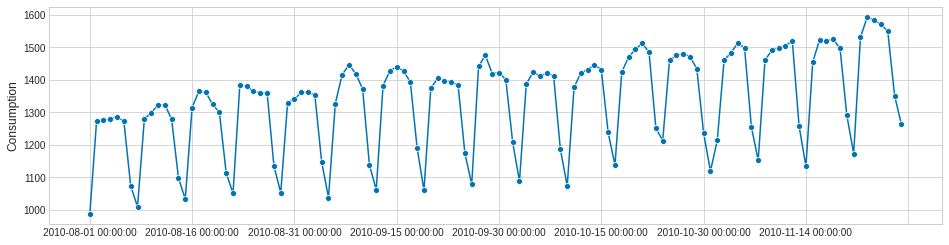

In [ ]:
z = ENP['Consumption'].loc['2010-08-01':'2010-11-28']
plot_series(z);

In [ ]:
kpss(z, regression = 'c')

(1.4899874976687209,
 0.01,
 3,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [ ]:
kpss(z, regression = 'ct')

(0.018189843168374513,
 0.1,
 3,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [ ]:
adfuller(z, regression='c', autolag='AIC')

(-0.0292078424100926,
 0.9560489265116855,
 13,
 106,
 {'1%': -3.4936021509366793,
  '5%': -2.8892174239808703,
  '10%': -2.58153320754717},
 1094.133761099994)

In [ ]:
adfuller(y, regression='ct', autolag='AIC')

(-2.1661140299050206,
 0.508934396108151,
 13,
 106,
 {'1%': -4.0468193247781725,
  '5%': -3.452751165593073,
  '10%': -3.151810567112449},
 1090.5743990887722)

## Автоарима

Попробуем оценить на наших данных SARIMA-модель. Делать это будем в рамках пакета pmdarima

In [ ]:
# pip install pmdarima

     |████████████████████████████████| 1.4 MB 423 kB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 13.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
import pmdarima as pm
from pmdarima import model_selection

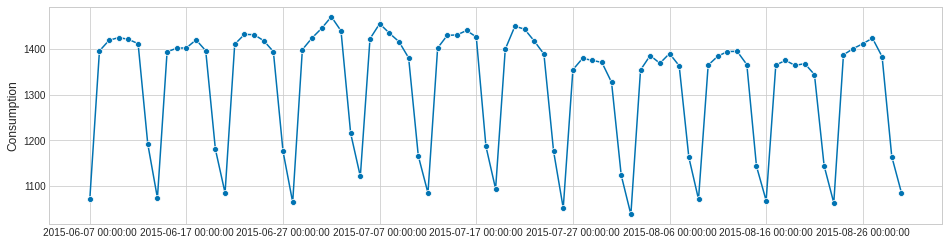

In [ ]:
y = ENP['Consumption'].loc['2015-06-07':'2015-08-30']
# z = ENP['Consumption'].loc['2010-08-01':'2010-11-28']
plot_series(y);

63 22


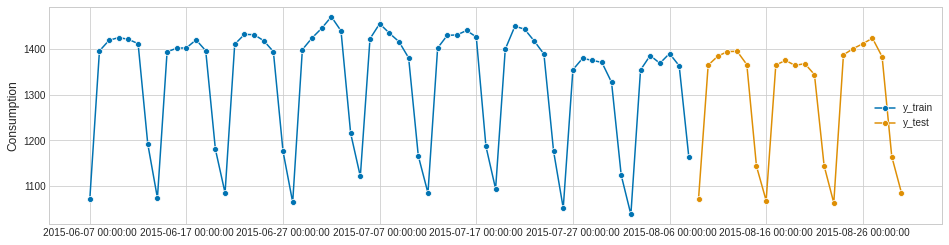

In [ ]:
y_train, y_test = temporal_train_test_split(y, test_size=22)
fh = ForecastingHorizon(y_test.index, is_relative=False)

plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [ ]:
arima_model_y = pm.auto_arima(

    y_train,
    start_p=1, start_q=1,
    max_p=5, max_q=5,

    seasonal=True, m = 7,
    start_P=0, start_Q=0,
    max_P = 2, max_Q = 2,

    max_D=2, max_d=2,
    alpha=0.05,
    test='kpss',
    seasonal_test='ocsb',

    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=False,
    n_fits=100,
    information_criterion='bic',
    out_of_sample_size=7
)

 ARIMA(0,0,0)(0,1,0)[7] intercept   : BIC=554.477, Time=0.10 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : BIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,1,2)[7] intercept   : BIC=inf, Time=0.99 sec
 ARIMA(0,0,0)(1,1,0)[7] intercept   : BIC=543.893, Time=0.54 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : BIC=547.817, Time=0.60 sec
 ARIMA(0,0,0)(1,1,2)[7] intercept   : BIC=inf, Time=1.66 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : BIC=547.612, Time=0.58 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : BIC=550.165, Time=0.78 sec
 ARIMA(0,0,0)(2,1,2)[7] intercept   : BIC=inf, Time=1.15 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : BIC=518.873, Time=0.17 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : BIC=505.751, Time=0.59 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : BIC=508.881, Time=1.57 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : BIC=504.754, Time=0.49 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : BIC=508.793, Time=1.08 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : BIC=511.176, Time=1.37 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : BIC

In [ ]:
arima_model_y.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   63
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 7)   Log Likelihood                -229.303
Date:                             Fri, 26 Nov 2021   AIC                            466.606
Time:                                     13:32:06   BIC                            474.708
Sample:                                          0   HQIC                           469.747
                                              - 63                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.4025      0.594     -0.677      0.498      -1.567       0.762
ar.L1          0.8640      0.077     11.252      0.000       0.714       1.015
ma.S.L7       -0.8906      0.328     -2.713      0.007      -1.534      -0.247
sigma2       174.4543     60.287      2.894      0.004      56.293     292.616
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.10
Prob(Q):                              0.91   Prob(JB):                         0.58
Heteroskedasticity (H):               1.75   Skew:                             0.03
Prob(H) (two-sided):                  0.23   Kurtosis:                         2.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

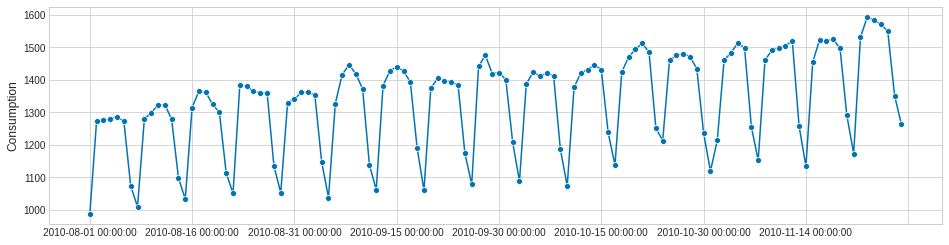

In [ ]:
z = ENP['Consumption'].loc['2010-08-01':'2010-11-28']
plot_series(z);

98 22


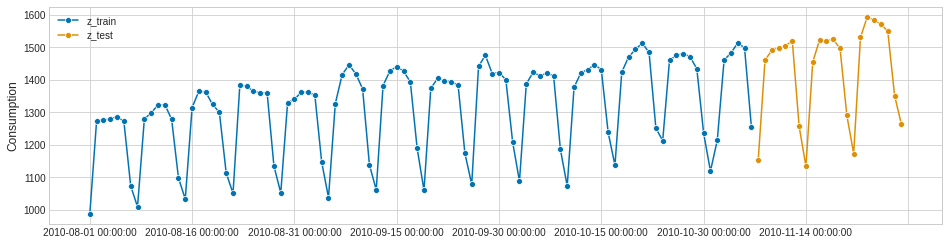

In [ ]:
z_train, z_test = temporal_train_test_split(z, test_size=22)
fh = ForecastingHorizon(z_test.index, is_relative=False)

plot_series(z_train, z_test, labels=["z_train", "z_test"])
print(z_train.shape[0], z_test.shape[0])

In [ ]:
arima_model_z = pm.auto_arima(

    z_train,
    start_p=1, start_q=1,
    max_p=5, max_q=5,

    seasonal=True, m = 7,
    start_P=0, start_Q=0,
    max_P = 2, max_Q = 2,

    max_D=2, max_d=2,
    alpha=0.05,
    test='kpss',
    seasonal_test='ocsb',

    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=False,
    n_fits=100,
    information_criterion='bic',
    out_of_sample_size=7
)

 ARIMA(0,0,0)(0,1,0)[7] intercept   : BIC=955.489, Time=0.11 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : BIC=inf, Time=0.53 sec
 ARIMA(0,0,0)(0,1,2)[7] intercept   : BIC=inf, Time=0.82 sec
 ARIMA(0,0,0)(1,1,0)[7] intercept   : BIC=962.718, Time=0.45 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : BIC=inf, Time=1.24 sec
 ARIMA(0,0,0)(1,1,2)[7] intercept   : BIC=inf, Time=0.93 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : BIC=951.400, Time=0.92 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : BIC=inf, Time=1.78 sec
 ARIMA(0,0,0)(2,1,2)[7] intercept   : BIC=inf, Time=1.60 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : BIC=930.381, Time=0.19 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : BIC=inf, Time=0.80 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : BIC=inf, Time=1.75 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : BIC=950.026, Time=0.74 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : BIC=inf, Time=0.95 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : BIC=inf, Time=1.70 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : BIC=955.558, Time=1.14 sec


In [ ]:
arima_model_z.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   98
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 7)   Log Likelihood                -457.188
Date:                           Fri, 26 Nov 2021   AIC                            920.376
Time:                                   13:52:35   BIC                            927.908
Sample:                                        0   HQIC                           923.414
                                            - 98                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.6472      4.199      1.345      0.179      -2.582      13.876
ar.L1          0.5471      0.039     14.165      0.000       0.471       0.623
sigma2      1164.1024     70.867     16.427      0.000    1025.205    1303.000
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):               369.45
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               4.83   Skew:                            -1.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
z_pred, z_pred_ci = arima_model_z.predict(
    n_periods=22,
    return_conf_int=True,
    alpha=0.05
)

mape(z_pred, z_test)

4.452178061292026

In [ ]:
df_forecast = pd.DataFrame({'z_pred': z_pred,
                            'ci_lower': z_pred_ci[:,0],
                            'ci_upper': z_pred_ci[:,1]})
df_forecast.index = fh
df_forecast.head()

,z_pred,ci_lower,ci_upper
2010-11-07,1135.220906,1068.349004,1202.092808
2010-11-08,1228.006389,1151.779598,1304.233181
2010-11-09,1474.524794,1395.713231,1553.336358
2010-11-10,1495.558807,1415.989806,1575.127807
2010-11-11,1526.150267,1446.355922,1605.944611


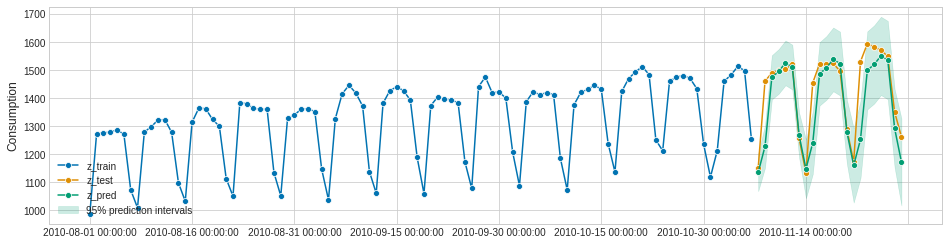

In [ ]:
fig, ax = plot_series(z_train,
                      z_test,
                      df_forecast.z_pred,
                      labels=["z_train", "z_test", "z_pred"]
                     );
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    df_forecast["ci_lower"],
    df_forecast["ci_upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"95% prediction intervals",
)
ax.legend(loc='lower left');

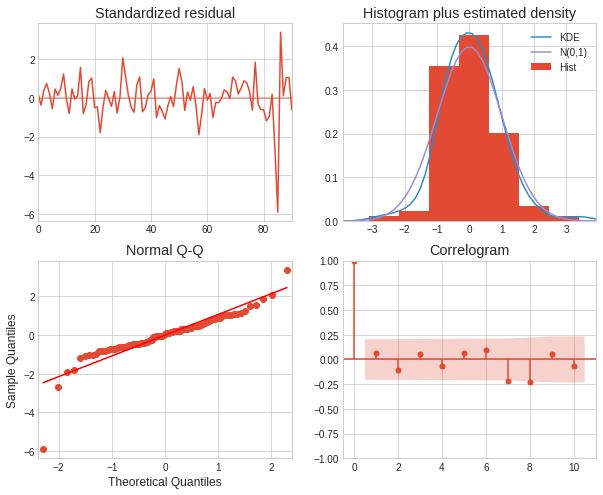

In [ ]:
arima_model_z.plot_diagnostics(figsize=(10, 8));

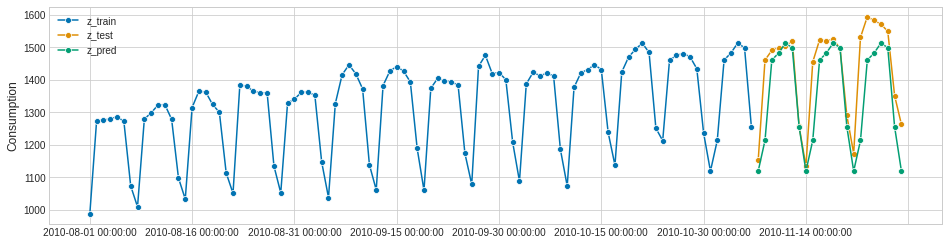

In [ ]:
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy="last", sp = 7)
forecaster.fit(z_train)

z_pred = forecaster.predict(fh)

plot_series(z_train, z_test, z_pred, labels=["z_train", "z_test", "z_pred"]);

In [ ]:
mape(z_pred, z_test)

9.727890084699393

In [ ]:
z_pred

2010-11-07    1118.753
2010-11-08    1213.349
2010-11-09    1460.858
2010-11-10    1482.434
2010-11-11    1513.322
2010-11-12    1498.494
2010-11-13    1255.457
2010-11-14    1118.753
2010-11-15    1213.349
2010-11-16    1460.858
2010-11-17    1482.434
2010-11-18    1513.322
2010-11-19    1498.494
2010-11-20    1255.457
2010-11-21    1118.753
2010-11-22    1213.349
2010-11-23    1460.858
2010-11-24    1482.434
2010-11-25    1513.322
2010-11-26    1498.494
2010-11-27    1255.457
2010-11-28    1118.753
dtype: float64